# Financial News Sentiment Analysis Project
## Part 4: LSTM Deep Learning Model

### Model Architecture
- **Input Layer**: Word2Vec embeddings (300-dim)
- **LSTM Layer**: 128 hidden units, bidirectional
- **Dropout**: 0.3 to prevent overfitting
- **Output Layer**: Fully connected + Softmax (3 classes)

### Expected Performance
- Improved accuracy over Naive Bayes (67.3%) to 85-92%
- Better sequence modeling capability
- Captures long-range dependencies

## 1. Setup & Load Data

In [29]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import pickle
import json
from pathlib import Path
from tqdm import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
print(f"✓ Libraries imported | PyTorch: {torch.__version__} | CUDA: {torch.cuda.is_available()}")

✓ Libraries imported | PyTorch: 2.5.1+cu121 | CUDA: True


In [30]:
# Configure paths and device
current_dir = Path.cwd()
if (current_dir / 'src').exists():
    project_root = current_dir
elif (current_dir.parent / 'src').exists():
    project_root = current_dir.parent
else:
    project_root = Path('c:/Users/xuzijian/Desktop/新闻情感/project')

data_dir = project_root / 'data' / 'train_test'
models_dir = project_root / 'models'
results_dir = project_root / 'results'

models_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# Set device and random seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"✓ Device: {device} | Project root: {project_root}")

✓ Device: cuda | Project root: c:\Users\xuzijian\Desktop\新闻情感\project


In [31]:
# Load datasets
train_df = pd.read_csv(data_dir / 'train.csv')
val_df = pd.read_csv(data_dir / 'validation.csv')
test_df = pd.read_csv(data_dir / 'test.csv')

y_train = np.load(data_dir / 'y_train.npy')
y_val = np.load(data_dir / 'y_val.npy')
y_test = np.load(data_dir / 'y_test.npy')

print(f"✓ Data loaded")
print(f"  Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"  Sentiment distribution: Positive={np.sum(y_train == 0)}, Neutral={np.sum(y_train == 1)}, Negative={np.sum(y_train == 2)}")

✓ Data loaded
  Train: 23500, Val: 2937, Test: 2938
  Sentiment distribution: Positive=5407, Neutral=8771, Negative=9322


## 2. Text Preprocessing & Word2Vec Embeddings

In [32]:
# Tokenize text for Word2Vec
def preprocess_text_for_embedding(text):
    """Preprocess text for Word2Vec"""
    if pd.isna(text):
        return []
    return text.lower().split()

train_texts = [preprocess_text_for_embedding(t) for t in train_df['text_cleaned']]
val_texts = [preprocess_text_for_embedding(t) for t in val_df['text_cleaned']]
test_texts = [preprocess_text_for_embedding(t) for t in test_df['text_cleaned']]

all_texts = train_texts + val_texts + test_texts

print(f"✓ Text tokenized: {len(all_texts)} total sequences")

✓ Text tokenized: 29375 total sequences


In [33]:
# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=all_texts,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=5
)

w2v_model.save(str(models_dir / 'word2vec_model.pkl'))
print(f"✓ Word2Vec trained | Vocab: {len(w2v_model.wv)}, Dim: {w2v_model.wv.vector_size}")

✓ Word2Vec trained | Vocab: 28664, Dim: 300


In [34]:
# Convert texts to word vector sequences
def texts_to_sequences(texts, w2v_model, max_length=100):
    """Convert tokenized texts to word vector matrices"""
    sequences = []
    lengths = []
    
    for text in tqdm(texts, desc="Converting"):
        vectors = []
        for word in text:
            if word in w2v_model.wv:
                vectors.append(w2v_model.wv[word])
        
        if len(vectors) > max_length:
            vectors = vectors[:max_length]
        
        seq_len = max(1, min(len(vectors), max_length))
        lengths.append(seq_len)
        
        while len(vectors) < max_length:
            vectors.append(np.zeros(300))
        
        sequences.append(np.array(vectors[:max_length]))
    
    return np.array(sequences), np.array(lengths)

X_train_seq, train_lengths = texts_to_sequences(train_texts, w2v_model)
X_val_seq, val_lengths = texts_to_sequences(val_texts, w2v_model)
X_test_seq, test_lengths = texts_to_sequences(test_texts, w2v_model)

print(f"✓ Text conversion completed")
print(f"  Train: {X_train_seq.shape}, Val: {X_val_seq.shape}, Test: {X_test_seq.shape}")

Converting: 100%|██████████| 23500/23500 [00:03<00:00, 6654.22it/s]

Converting: 100%|██████████| 2937/2937 [00:00<00:00, 6276.59it/s]

Converting: 100%|██████████| 2938/2938 [00:00<00:00, 7237.02it/s]



✓ Text conversion completed
  Train: (23500, 100, 300), Val: (2937, 100, 300), Test: (2938, 100, 300)


In [35]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_seq).to(device)
X_val_tensor = torch.FloatTensor(X_val_seq).to(device)
X_test_tensor = torch.FloatTensor(X_test_seq).to(device)

y_train_tensor = torch.LongTensor(y_train).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

train_lengths_tensor = torch.LongTensor(train_lengths).to(device)
val_lengths_tensor = torch.LongTensor(val_lengths).to(device)
test_lengths_tensor = torch.LongTensor(test_lengths).to(device)

print(f"✓ Tensors created: {X_train_tensor.shape}")

✓ Tensors created: torch.Size([23500, 100, 300])


In [36]:
# Create data loaders
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor, train_lengths_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor, val_lengths_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, test_lengths_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✓ Data loaders created (batch_size={batch_size})")

✓ Data loaders created (batch_size=32)


## 3. Define LSTM Model

In [37]:
# Define LSTM model
class SentimentLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes, num_layers=2, dropout=0.3):
        super(SentimentLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x, lengths):
        # Pack padded sequence
        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        packed_output, (hidden, cell) = self.lstm(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Use last hidden states (bidirectional)
        forward_hidden = hidden[-2]
        backward_hidden = hidden[-1]
        combined = torch.cat([forward_hidden, backward_hidden], dim=1)
        
        # Fully connected layers
        x = self.dropout(combined)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

print("✓ LSTM model defined")

✓ LSTM model defined


## 4. Model Training

In [38]:
# Initialize model
model = SentimentLSTM(
    embedding_dim=300,
    hidden_dim=128,
    num_classes=3,
    num_layers=2,
    dropout=0.3
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model initialized | Total params: {total_params:,} | Trainable: {trainable_params:,}")

✓ Model initialized | Total params: 868,867 | Trainable: 868,867


In [39]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

print(f"✓ Loss: CrossEntropyLoss | Optimizer: Adam (lr=0.001) | Scheduler: ReduceLROnPlateau")

✓ Loss: CrossEntropyLoss | Optimizer: Adam (lr=0.001) | Scheduler: ReduceLROnPlateau


In [40]:
# Training and validation functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch, lengths_batch in tqdm(train_loader, desc="Training", leave=False):
        outputs = model(X_batch, lengths_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    
    return total_loss / len(train_loader), correct / total

def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch, lengths_batch in val_loader:
            outputs = model(X_batch, lengths_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    
    return total_loss / len(val_loader), correct / total

print("✓ Training functions defined")

✓ Training functions defined


In [41]:
# Train the model
num_epochs = 20
patience = 3
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"Starting training for {num_epochs} epochs...\n")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), models_dir / 'lstm_model_best.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

print(f"\n✓ Training completed | Best val loss: {best_val_loss:.4f}")

Starting training for 20 epochs...



Epoch 01/20 | Train Loss: 0.8392, Acc: 0.6089 | Val Loss: 0.7700, Acc: 0.6289


Epoch 02/20 | Train Loss: 0.7508, Acc: 0.6605 | Val Loss: 0.7251, Acc: 0.6742


Epoch 03/20 | Train Loss: 0.7104, Acc: 0.6852 | Val Loss: 0.7073, Acc: 0.6868


Epoch 04/20 | Train Loss: 0.6815, Acc: 0.6968 | Val Loss: 0.6620, Acc: 0.7079


Epoch 05/20 | Train Loss: 0.6686, Acc: 0.7037 | Val Loss: 0.6670, Acc: 0.7004


Epoch 06/20 | Train Loss: 0.6604, Acc: 0.7079 | Val Loss: 0.6584, Acc: 0.7065


Epoch 07/20 | Train Loss: 0.6520, Acc: 0.7146 | Val Loss: 0.6671, Acc: 0.6987


Epoch 08/20 | Train Loss: 0.6444, Acc: 0.7131 | Val Loss: 0.6481, Acc: 0.7181


Epoch 09/20 | Train Loss: 0.6401, Acc: 0.7139 | Val Loss: 0.6539, Acc: 0.7072


Epoch 10/20 | Train Loss: 0.6336, Acc: 0.7197 | Val Loss: 0.6429, Acc: 0.7140


Epoch 11/20 | Train Loss: 0.6333, Acc: 0.7203 | Val Loss: 0.6424, Acc: 0.7181


Epoch 12/20 | Train Loss: 0.6250, Acc: 0.7233 | Val Loss: 0.6458, Acc: 0.7143


Epoch 13/20 | Train Loss: 0.6221, Acc: 0.7251 | Val Loss: 0.6450, Acc: 0.7130


Epoch 14/20 | Train Loss: 0.6170, Acc: 0.7262 | Val Loss: 0.6488, Acc: 0.7177

Early stopping triggered after 14 epochs

✓ Training completed | Best val loss: 0.6424


In [42]:
# Load best model for evaluation
model.load_state_dict(torch.load(models_dir / 'lstm_model_best.pth'))
print("✓ Best model loaded for evaluation")

✓ Best model loaded for evaluation


## 5. Model Evaluation

In [43]:
# Generate predictions
def predict(model, data_loader, device):
    """Generate predictions"""
    model.eval()
    y_pred = []
    y_proba = []
    
    with torch.no_grad():
        for X_batch, y_batch, lengths_batch in data_loader:
            outputs = model(X_batch, lengths_batch)
            proba = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_proba.extend(proba.cpu().numpy())
    
    return np.array(y_pred), np.array(y_proba)

y_train_pred, y_train_proba = predict(model, train_loader, device)
y_val_pred, y_val_proba = predict(model, val_loader, device)
y_test_pred, y_test_proba = predict(model, test_loader, device)

print(f"✓ Predictions generated")

✓ Predictions generated


In [44]:
# Compute evaluation metrics
def compute_metrics(y_true, y_pred, y_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
    }

train_metrics = compute_metrics(y_train, y_train_pred, y_train_proba)
val_metrics = compute_metrics(y_val, y_val_pred, y_val_proba)
test_metrics = compute_metrics(y_test, y_test_pred, y_test_proba)

print("\nLSTM Model Evaluation Results")
print("="*60)
print(f"Train - Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1']:.4f}")
print(f"Val   - Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}")
print(f"Test  - Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1']:.4f}")
print("="*60)


LSTM Model Evaluation Results
Train - Acc: 0.3657, F1: 0.3496
Val   - Acc: 0.7181, F1: 0.7081
Test  - Acc: 0.7032, F1: 0.6899


In [45]:
# Classification report
label_names = ['Positive', 'Neutral', 'Negative']

print("\nTest Set - Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_names, digits=4))


Test Set - Classification Report:
              precision    recall  f1-score   support

    Positive     0.7681    0.3778    0.5065       675
     Neutral     0.7465    0.7730    0.7595      1097
    Negative     0.6551    0.8259    0.7307      1166

    accuracy                         0.7032      2938
   macro avg     0.7232    0.6589    0.6655      2938
weighted avg     0.7152    0.7032    0.6899      2938



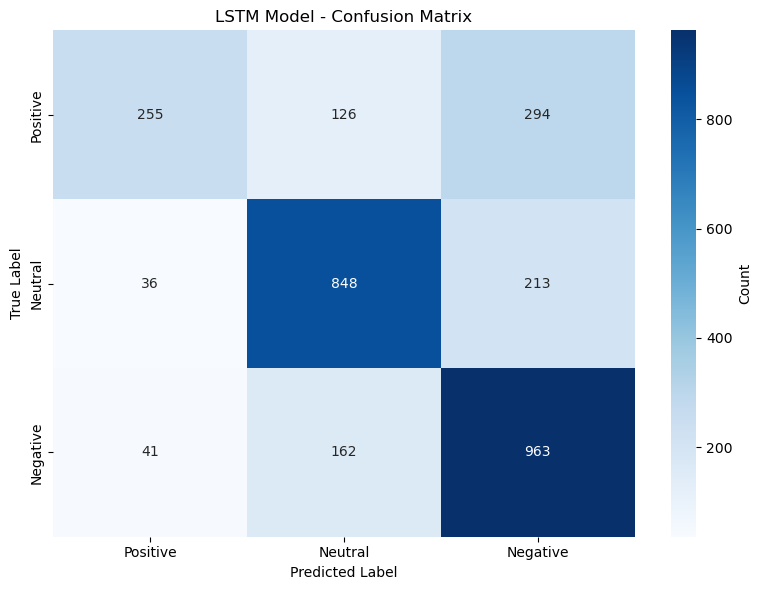

✓ Confusion matrix saved


In [46]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('LSTM Model - Confusion Matrix')
plt.tight_layout()
plt.savefig(results_dir / 'cm_lstm.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved")

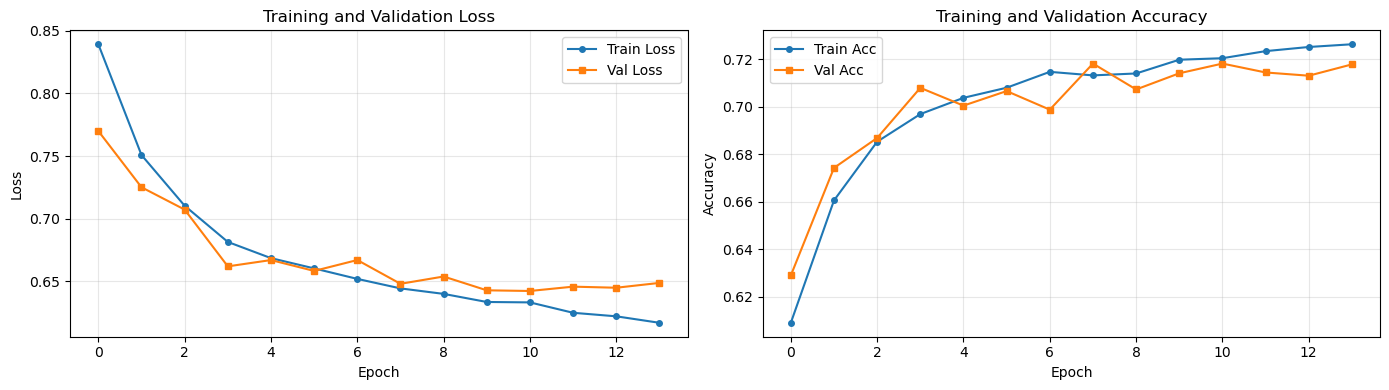

✓ Training curves saved


In [47]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(train_losses, label='Train Loss', marker='o', markersize=4)
axes[0].plot(val_losses, label='Val Loss', marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs, label='Train Acc', marker='o', markersize=4)
axes[1].plot(val_accs, label='Val Acc', marker='s', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'training_curves_lstm.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved")

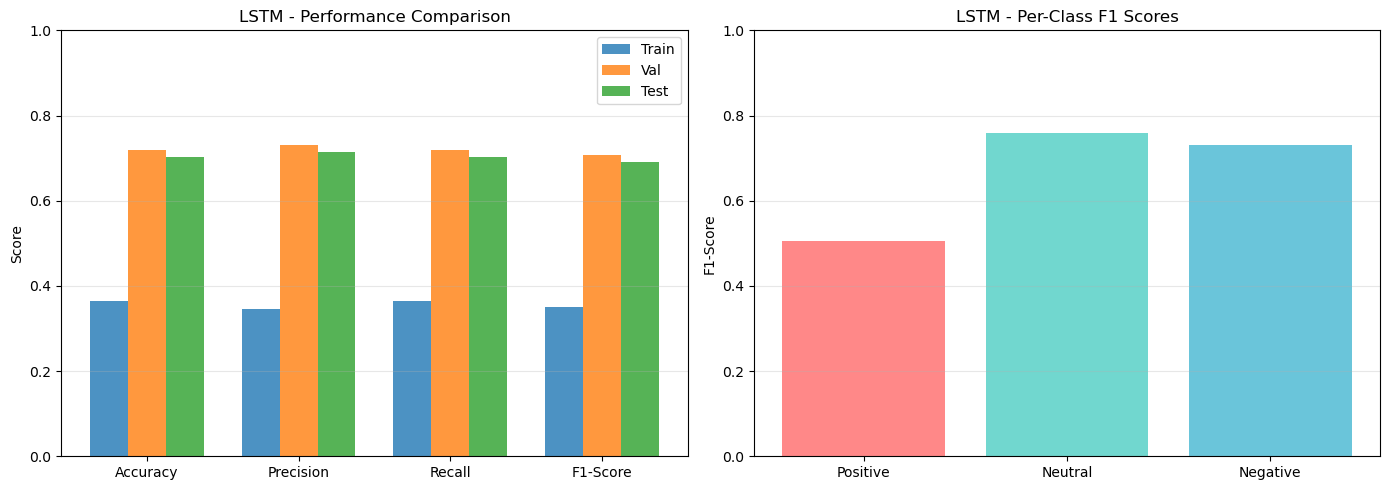

✓ Performance metrics saved


In [48]:
# Performance comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_vals = [train_metrics['accuracy'], train_metrics['precision'], train_metrics['recall'], train_metrics['f1']]
val_vals = [val_metrics['accuracy'], val_metrics['precision'], val_metrics['recall'], val_metrics['f1']]
test_vals = [test_metrics['accuracy'], test_metrics['precision'], test_metrics['recall'], test_metrics['f1']]

x = np.arange(len(metrics_names))
width = 0.25

axes[0].bar(x - width, train_vals, width, label='Train', alpha=0.8)
axes[0].bar(x, val_vals, width, label='Val', alpha=0.8)
axes[0].bar(x + width, test_vals, width, label='Test', alpha=0.8)
axes[0].set_ylabel('Score')
axes[0].set_title('LSTM - Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Per-class F1 scores
f1_per_class = f1_score(y_test, y_test_pred, average=None, zero_division=0)
axes[1].bar(label_names, f1_per_class, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
axes[1].set_ylabel('F1-Score')
axes[1].set_title('LSTM - Per-Class F1 Scores')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'metrics_lstm.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Performance metrics saved")

In [49]:
# Save predictions
predictions_df = test_df.copy()
predictions_df['predicted'] = y_test_pred
predictions_df['predicted_proba_positive'] = y_test_proba[:, 0]
predictions_df['predicted_proba_neutral'] = y_test_proba[:, 1]
predictions_df['predicted_proba_negative'] = y_test_proba[:, 2]

predictions_df.to_csv(results_dir / 'lstm_predictions.csv', index=False)

# Save final model
torch.save(model.state_dict(), models_dir / 'lstm_model_final.pt')

print("✓ Predictions and model saved")

✓ Predictions and model saved


## 6. Save Results

In [50]:
# Save results summary
results_summary = {
    'model_name': 'LSTM with Word2Vec',
    'architecture': {
        'embedding': {
            'type': 'Word2Vec',
            'dimension': 300,
            'window': 5,
            'min_count': 2
        },
        'lstm': {
            'num_layers': 2,
            'hidden_dim': 128,
            'bidirectional': True,
            'dropout': 0.3
        },
        'total_parameters': int(total_params),
        'trainable_parameters': int(trainable_params)
    },
    'training_config': {
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'batch_size': batch_size,
        'epochs_trained': len(train_losses),
        'early_stopping': True,
        'patience': patience
    },
    'train_metrics': {k: float(v) for k, v in train_metrics.items()},
    'val_metrics': {k: float(v) for k, v in val_metrics.items()},
    'test_metrics': {k: float(v) for k, v in test_metrics.items()},
    'confusion_matrix': cm.tolist()
}

with open(results_dir / 'lstm_results.json', 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, ensure_ascii=False, indent=2)

print(f"✓ Results summary saved")

✓ Results summary saved


In [52]:
# Final summary
print("\n" + "="*70)
print("LSTM Model Training Summary")
print("="*70)

print(f"\nModel Performance:")
print(f"  Test Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"  Test F1:        {test_metrics['f1']:.4f}")
print(f"  Test Precision: {test_metrics['precision']:.4f}")
print(f"  Test Recall:    {test_metrics['recall']:.4f}")

print(f"\nModel Configuration:")
print(f"  Embedding Dim:  300 (Word2Vec)")
print(f"  LSTM Layers:    {results_summary['architecture']['lstm']['num_layers']}")
print(f"  Total Params:   {results_summary['architecture']['total_parameters']:,}")
print(f"  Epochs Trained: {results_summary['training_config']['epochs_trained']}")

print(f"\n✓ All results saved to: {results_dir}")
print("="*70)


LSTM Model Training Summary

Model Performance:
  Test Accuracy:  0.7032 (70.32%)
  Test F1:        0.6899
  Test Precision: 0.7152
  Test Recall:    0.7032

Model Configuration:
  Embedding Dim:  300 (Word2Vec)
  LSTM Layers:    2
  Total Params:   868,867
  Epochs Trained: 14

✓ All results saved to: c:\Users\xuzijian\Desktop\新闻情感\project\results
